In [2]:
import os
# tensorflow version
import tensorflow

# keras version
import keras

from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model



In [3]:
from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical



In [4]:
import string
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

# 1. Loading the Dataset:

In [5]:


token_path = "./Flickr8k_text/Flickr8k.token.txt"
train_images_path = './Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = './Flickr8k_text/Flickr_8k.testImages.txt'
images_path = './Flicker8k_Dataset/'
glove_path = './glove/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


#### Creating a descriptions list 

#### Create a dictionary with the names of the images as keys along with the 5 captions for the image as captions

In [6]:

descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

#### Convert descriptions to lowercase and remove punctuation 

In [7]:



table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

#### Saving the descriptions as pickle file for later use.

In [8]:


import pickle
with open('descriptions.pkl','wb') as f:
    pickle.dump(descriptions, f)

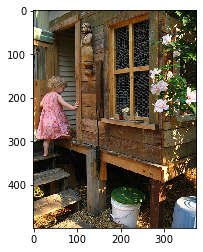

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [8]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

#### Create a vocabulary of unique words present across all the images in the data set

In [9]:


vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

# Here we get 8828 unique words in the 40000 image captions

Original Vocabulary Size: 8828


#### Save the image id's and the cleaned captions

In [10]:

lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

#### Load the images from dataset to the train variable

In [11]:


doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

####  save training images to train_img
####  save testing images to test_img

In [12]:

img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

#### Load the descriptions into a dictionary
#### Add to tokens to every caption i.e ‘startseq’ and ‘endseq’

In [13]:


train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)



#### Make a list of all the training captions

In [14]:

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

#### Reduce the vocabulary to only the words that occur atleast 10 times

In [15]:

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


#### create two dicts to map 1. words to an index 2. index to words

In [18]:


ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [19]:

import pickle
with open("ixtoword.pkl","wb") as f:
    pickle.dump(ixtoword,f)

#### Find the max length of caption

In [17]:

all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


#### map all the words in our 38-word long caption to a 200-dimension vector using Glove

In [18]:

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

####   make matrix of shape (1660,200) 

In [19]:

embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#### Load the inceptionV3 model

In [20]:

model = InceptionV3(weights='imagenet')

#### We remove the softmax layer from the model as we are not classfying but rather extracting image vector for our images

In [21]:

model_new = Model(model.input, model.layers[-2].output)

#### Reshape images to 299 x 299

In [22]:

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

### encode training and testing images

In [23]:

def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

#### 1. Sequence is processed from the text
#### 2. Image is used to extract feature vector
#### 3. Concatenate the above two layers and decode output using softmax


In [24]:


inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

### make the weights in the embedding layer not trainable

In [25]:

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### Compile the model using Categorical_Crossentropy Loss function and Adam optimizer

In [26]:

model.compile(loss='categorical_crossentropy', optimizer='adam')

### Function to train data in batches

In [27]:


def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [29]:

type(wordtoix)

import pickle
with open("wordtoix_dict.pkl","wb") as f:
    pickle.dump(wordtoix,f)


In [30]:
with open("encoding_train.pkl","wb") as f:
    pickle.dump(encoding_train,f)
with open("encoding_test.pkl","wb") as f:
    pickle.dump(encoding_test,f)

### train model for 30 epochs.

In [27]:

epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 163s 80ms/step - loss: 3.6920
Epoch 2/30
2000/2000 [==============================] - 158s 79ms/step - loss: 3.0334
Epoch 3/30
2000/2000 [==============================] - 159s 79ms/step - loss: 2.8361
Epoch 4/30
2000/2000 [==============================] - 160s 80ms/step - loss: 2.7180
Epoch 5/30
2000/2000 [==============================] - 160s 80ms/step - loss: 2.6341
Epoch 6/30
2000/2000 [==============================] - 162s 81ms/step - loss: 2.5696
Epoch 7/30
2000/2000 [==============================] - 160s 80ms/step - loss: 2.5181
Epoch 8/30
2000/2000 [==============================] - 162s 81ms/step - loss: 2.4775
Epoch 9/30
2000/2000 [==============================] - 162s 81ms/step - loss: 2.4421
Epoch 10/30
2000/2000 [==============================] - 161s 80ms/step - loss: 2.4125
Epoch 11/30
2000/2000 [==============================] - 163s 81ms/step - loss: 2.3865
Epoch 12/30
2000/2000 [=============================

In [28]:
model.save_model('saved_model/')

AttributeError: 'Functional' object has no attribute 'save_model'

In [30]:
model.save('saved_model/comp_model.hdf5')

/usr/lib/python3/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### A vector generated by the model is greedily picked to find the next word prediction.

In [31]:


def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

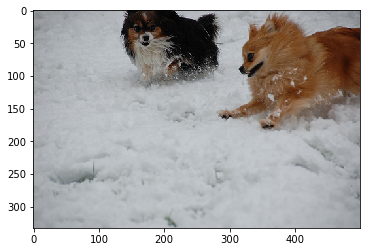

Greedy Search: a dog is running through the snow


In [32]:

pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

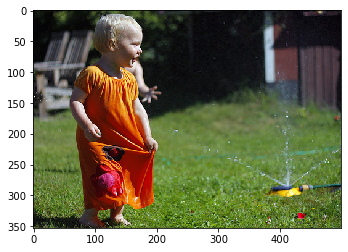

Greedy Search: a boy in a red shirt is running through a grassy area


In [33]:
pic = '3767841911_6678052eb6.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

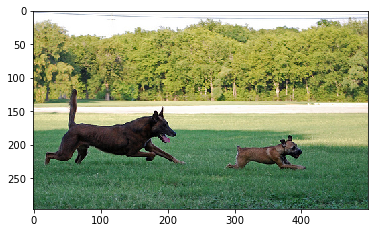

Greedy Search: a brown dog is running through a grassy field


In [34]:
pic = '2723477522_d89f5ac62b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))

#### Find the top k predictions and refeed into model then sort based on the probablities returened by model. We repeat till we reach 'endseq' or the max length

In [35]:

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

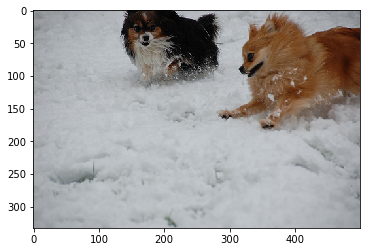

Greedy Search: a dog is running through the snow
Beam Search, K = 3: a black and brown dog is running through the snow
Beam Search, K = 5: a brown and white dog is running through the snow
Beam Search, K = 7: a brown and white dog is running through the snow
Beam Search, K = 10: a brown and white dog is playing with a toy in the snow


In [36]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

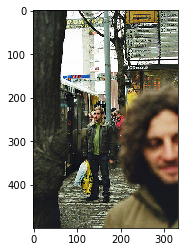

Greedy Search: a woman in a black dress and a man in a white suit are standing in front of a building
Beam Search, K = 3: a woman in a white shirt walks down the street
Beam Search, K = 5: a group of people wait to cross a street
Beam Search, K = 7: a group of people wait to cross the street
Beam Search, K = 10: a group of people wait to cross the street


In [37]:
pic = '3344233740_c010378da7.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

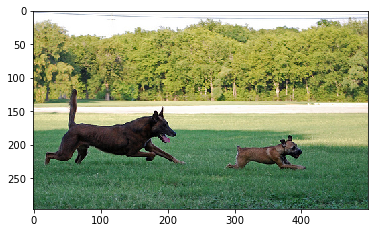

Greedy Search: a brown dog is running through a grassy field
Beam Search, K = 3: a brown dog and a brown and white dog are playing tug of war
Beam Search, K = 5: a brown dog and a brown and white dog are playing tug of war
Beam Search, K = 7: a brown dog and a brown and white dog are playing tug of war
Beam Search, K = 10: there is a brown dog and a brown and white dog are playing tug of war


In [38]:
pic = '2723477522_d89f5ac62b.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

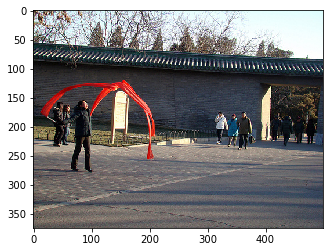

Greedy Search: a man in a red shirt is standing on a sidewalk
Beam Search, K = 3: a group of people stand on the edge of a road
Beam Search, K = 5: a group of people walking down the street
Beam Search, K = 7: a group of people walk down the street in a parking lot
Beam Search, K = 10: a group of people wait to cross a city street
[['an', 'asian', 'girl', 'performs', 'a', 'routine', 'with', 'two', 'red', 'flags', 'in', 'a', 'square'], ['a', 'person', 'waving', 'long', 'red', 'flags'], ['a', 'woman', 'plays', 'with', 'long', 'red', 'ribbons', 'in', 'an', 'empty', 'square'], ['lady', 'waving', 'two', 'long', 'red', 'streamers', 'around'], ['two', 'people', 'work', 'with', 'long', 'ribbons', 'in', 'a', 'chinese', 'courtyard']]
[['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'on', 'a', 'sidewalk'], ['a', 'group', 'of', 'people', 'stand', 'on', 'the', 'edge', 'of', 'a', 'road'], ['a', 'group', 'of', 'people', 'walking', 'down', 'the', 'street'], ['a', 'group', 'of', 'people', 'wa

/home/aditya/aditya/642_proj/env/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/aditya/aditya/642_proj/env/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/aditya/aditya/642_proj/env/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

In [88]:
pic_name = '3207358897_bfa61fa3c6'
pic = f'{pic_name}.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
temp_true_data = descriptions[pic_name]
temp_predicted_data = [greedySearch(image),beam_search_predictions(image, beam_index = 3),beam_search_predictions(image, beam_index = 5),beam_search_predictions(image, beam_index = 7),beam_search_predictions(image, beam_index = 10)]
print("Greedy Search:",temp_predicted_data[0])
print("Beam Search, K = 3:",temp_predicted_data[1])
print("Beam Search, K = 5:",temp_predicted_data[2])
print("Beam Search, K = 7:",temp_predicted_data[3])
print("Beam Search, K = 10:",temp_predicted_data[4])
import nltk
from nltk.translate import bleu_score
from nltk.tokenize import word_tokenize

temp_true_data = [word_tokenize(i) for i in temp_true_data]
print(temp_true_data)
temp_predicted_data = [word_tokenize(i) for i in temp_predicted_data]
print(temp_predicted_data)
s1 = []
for pred in temp_predicted_data:
    s1.append(bleu_score.sentence_bleu(temp_true_data,pred))
s2= bleu_score.corpus_bleu(temp_true_data, temp_predicted_data)
print(s1)
print(s2)


### BLEU score calculation

In [89]:

s1 = []
sf = bleu_score.SmoothingFunction()
for pred in temp_predicted_data:
    s1.append(bleu_score.sentence_bleu(temp_true_data,pred,smoothing_function=sf.method3,weights=(0.99, 0.00, 0.00, 0.00)))
s2= bleu_score.corpus_bleu(temp_true_data, temp_predicted_data,smoothing_function=sf.method3)
print([' '.join(i) for i in temp_true_data])
print(list(zip([' '.join(i) for i in temp_predicted_data],s1)))
print(s2)

['an asian girl performs a routine with two red flags in a square', 'a person waving long red flags', 'a woman plays with long red ribbons in an empty square', 'lady waving two long red streamers around', 'two people work with long ribbons in a chinese courtyard']
[('a man in a red shirt is standing on a sidewalk', 0.08913765521398126), ('a group of people stand on the edge of a road', 0.04932351569489709), ('a group of people walking down the street', 0.06567274736060397), ('a group of people walk down the street in a parking lot', 0.08054496384843701), ('a group of people wait to cross a city street', 0.05522397783539469)]
0.012534435073244204


In [90]:
len(test_images)

1000